In [48]:
print("Hello World")

Hello World


In [49]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os, sys
from scipy.io import mmread
import scipy.sparse as sp
from IPython.display import Image
import scanpy as sc
import seaborn as sns

In [50]:
import TS_colorDict
sex_color_dict = {"F": '#ac4962', 'M': '#546e9a'}

In [51]:
sc.settings.verbosity = 1  
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(5, 5))

-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                 10.3.0
TS_colorDict        NA
asttokens           NA
backcall            0.2.0
bottleneck          1.3.7
brotli              1.0.9
certifi             2025.04.26
charset_normalizer  3.3.2
comm                0.2.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.6.7
decorator           5.1.1
exceptiongroup      1.2.0
executing           0.8.3
gseapy              1.1.3
h5py                3.11.0
idna                3.7
igraph              0.11.5
importlib_resources NA
ipykernel           6.28.0
jedi                0.18.1
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
leidenalg           0.10.2
llvmlite            0.42.0
matplotlib          3.7.5
matplotlib_inline   0.1.6
mpl_toolkits        NA
natsort             8.4.0
numba               0.59.1
numexpr             2.8.7
numpy               1.26.4
packaging           24.0
pandas        

In [5]:
countfn = "./../tabula_sapiens/TabulaSapiens_subset_objects_V2/TSP1_30_version2d_senescent_cells_raw_counts_senescence_genes_by_donor_tissue_broadcelltype_in_donor_tissue_broadcelltypes.h5ad"

In [6]:
run_name = 'TSP1_30_version2d_cNMF_senescent_cells_raw_counts_senescence_genes_by_donor_tissue_broadcelltype_in_donor_tissue_broadcelltypes_parallel_k1050_iter10_sc'
selected_K = 34
density_threshold = 0.1

In [7]:
adata = sc.read(countfn)
adata.X = sp.csr_matrix(adata.X)
adata.X = adata.X.astype(np.float64)
adata

AnnData object with n_obs × n_vars = 804 × 3792
    obs: 'donor', 'tissue', 'broad_cell_class', 'donor_tissue_broadcelltype'

3792


/hpc/mydata/madhav.mantri/conda_envs/python3.9/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


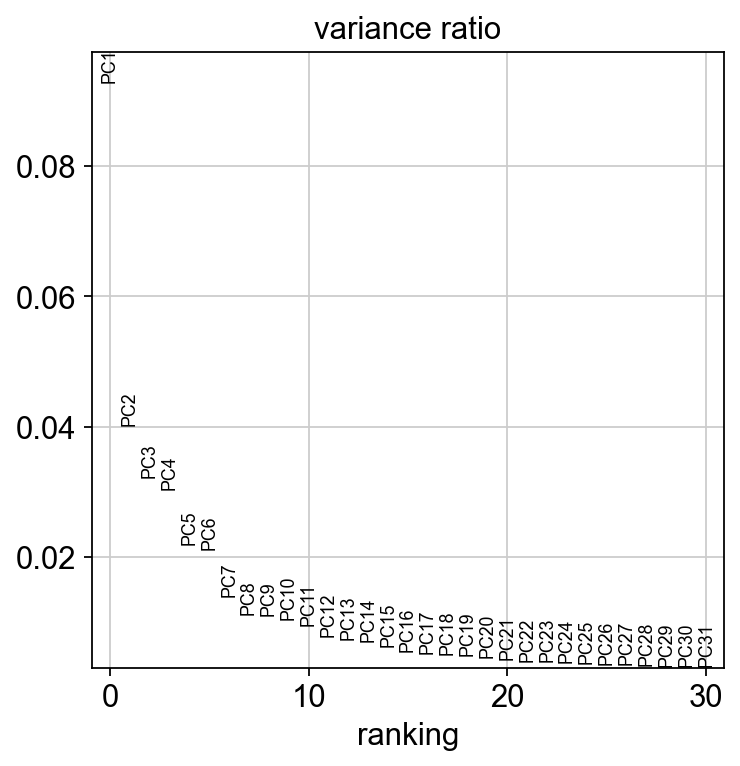

In [8]:
## Obtain high variance genes that were used for cNMF as these were saved to a text file
hvgs = open('./../tabula_sapiens/cNMF/' + run_name + "/" + run_name + '.overdispersed_genes.txt').read().split('\n')
print(len(hvgs))
# sc.pp.normalize_per_cell(adata, counts_per_cell_after=10**4) ## TPT normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata.copy()
adata = adata[:,hvgs]
sc.pp.scale(adata)
sc.pp.pca(adata)
sc.pl.pca_variance_ratio(adata, log=False)

In [9]:
sc.pp.neighbors(adata, n_pcs=20)
sc.tl.leiden(adata, resolution=0.2)
sc.tl.umap(adata)

/hpc/mydata/madhav.mantri/conda_envs/python3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_3357815/3953807454.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.2)


In [10]:
metadata = pd.read_csv("./../tabula_sapiens/TabulaSapiens_subset_objects_V2/TSP1_30_version2d_metadata_filtered0.csv", index_col=0)
donor_tissue_celltype_metadata = metadata[["donor", "tissue", "broad_cell_class", "compartment", "tissue_broadcelltype", "donor_tissue_broadcelltype"]]
donor_tissue_celltype_metadata = donor_tissue_celltype_metadata.reset_index(drop=True).drop_duplicates().set_index("donor_tissue_broadcelltype", drop=False)
adata.obs = donor_tissue_celltype_metadata.drop_duplicates(subset = "donor_tissue_broadcelltype").loc[adata.obs_names]
donor_tissue_celltype_metadata.shape

/tmp/ipykernel_3357815/1571387337.py:1: DtypeWarning: Columns (5,6,7,8,9,13,14,15,43) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("./../tabula_sapiens/TabulaSapiens_subset_objects_V2/TSP1_30_version2d_metadata_filtered0.csv", index_col=0)


(1313, 6)

In [11]:
celltypes_order = adata.obs["broad_cell_class"].astype("category").cat.categories.values
celltype_colors = pd.read_csv("./../tabula_sapiens/BroadCellTypeColorPalette.csv", index_col=0).set_index("broadct").loc[celltypes_order]["col_colors"]
celltypes_order = [x.capitalize() for x in celltypes_order]
celltype_colors = {key.capitalize(): value for key, value in celltype_colors.items()}
adata.obs["broad_cell_class1"] = adata.obs["broad_cell_class"].astype(str).str.capitalize().astype("category").cat.reorder_categories(celltypes_order)

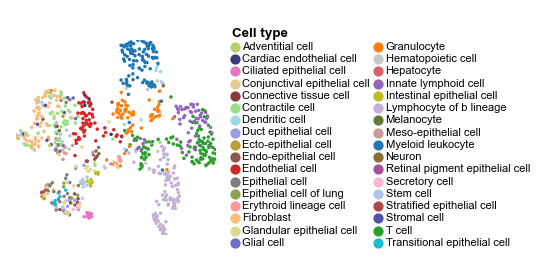

In [12]:
sc.settings.set_figure_params(dpi = 80, dpi_save= 300, fontsize=6, facecolor='white', frameon=True, figsize=(2.0, 2.0), vector_friendly = False, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize = (1.6, 1.6))
plt.margins(x=0, y=0)
sc.pl.umap(adata, color = ['broad_cell_class1'], size=10, legend_fontsize=5, sort_order=True, frameon=False, palette = celltype_colors,
           title="", na_in_legend = False, show=False, ax = ax)
plt.legend(ncol=2, prop={'size': 5}, handletextpad=0.4, markerscale = 0.6, frameon = False, borderpad=1, columnspacing=0.5,
           labelspacing = 0.2, loc = 6, bbox_to_anchor = (1.0,0.5), title = "Cell type", alignment = "left",
          title_fontproperties={'weight':'bold'})
# ax.set_ylabel("UMAP2", labelpad = 0.5)
# ax.set_xlabel("UMAP1", labelpad = 0.5)
# plt.savefig("human_figures/SCs_DTC_celltypes.pdf")
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=True, figsize=(3.0, 3.0), vector_friendly = False)

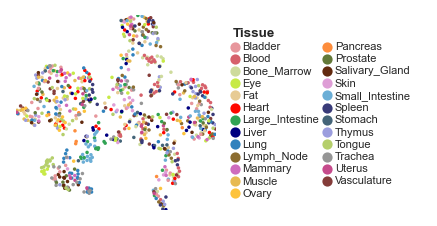

In [295]:
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=True, figsize=(2.0, 2.0), vector_friendly = False, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize = (1.6, 1.6))
plt.margins(x=0, y=0)
sc.pl.umap(adata, color = ['tissue'], size=10, legend_fontsize=5, sort_order=True, frameon=False, palette = TS_colorDict.tissue_colors(),
           title="", na_in_legend = False, show=False, ax = ax)
plt.legend(ncol=2, prop={'size': 5}, handletextpad=0.4, markerscale = 0.6, frameon = False, borderpad=1, columnspacing=0.5,
           labelspacing = 0.2, loc = 6, bbox_to_anchor = (1.0,0.5), title = "Tissue", alignment = "left",
          title_fontproperties={'weight':'bold'})
# ax.set_ylabel("UMAP2", labelpad = 0.5)
# ax.set_xlabel("UMAP1", labelpad = 0.5)
# plt.tight_layout()
plt.savefig("human_figures/SCs_DTC_tissues.pdf")
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=True, figsize=(3.0, 3.0), vector_friendly = False)

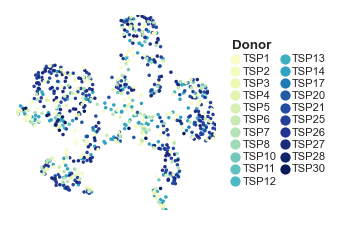

In [296]:
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=True, figsize=(2.0, 2.0), vector_friendly = False, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize = (1.6, 1.6))
plt.margins(x=0, y=0)
sc.pl.umap(adata, color = ['donor'], size=10, legend_fontsize=5, sort_order=True, frameon=False, palette = TS_colorDict.donor_colors(),
           title="", na_in_legend = False, show=False, ax = ax)
plt.legend(ncol=2, prop={'size': 5}, handletextpad=0.4, markerscale = 0.6, frameon = False, borderpad=1, columnspacing=0.5,
           labelspacing = 0.2, loc = 6, bbox_to_anchor = (1.0,0.5), title = "Donor", alignment = "left",
          title_fontproperties={'weight':'bold'})
# ax.set_ylabel("UMAP2", labelpad = 0.5)
# ax.set_xlabel("UMAP1", labelpad = 0.5) 
plt.savefig("human_figures/SCs_DTC_donor.pdf")
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=True, figsize=(3.0, 3.0), vector_friendly = False)

{'endothelial': '#ffe793', 'epithelial': '#febf5a', 'immune': '#fd8c3c', 'stromal': '#f43d25', 'germline': '#c90823', 'neural': '#800026'}


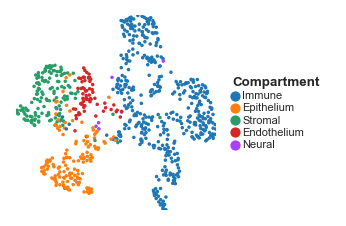

In [297]:
print(TS_colorDict.compartment_colors())
# complartment_colors = {'Endothelium': '#ffe793',
#  'Epithelium': '#febf5a',
#  'Immune': '#fd8c3c',
#  'Stromal': '#f43d25',
#  'Germline': '#c90823',
#  'Neural': '#800026'} 
adata.obs["compartment"] = adata.obs["compartment"].cat.reorder_categories(["Immune", "Epithelium", "Stromal", "Endothelium", "Neural"])


sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=True, figsize=(2.0, 2.0), vector_friendly = False, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize = (1.6, 1.6))
plt.margins(x=0, y=0)
sc.pl.umap(adata, color = ['compartment'], size=10, legend_fontsize=5, sort_order=True, frameon=False, 
           title="", na_in_legend = False, show=False, ax = ax)
plt.legend(ncol=1, prop={'size': 5}, handletextpad=0.4, markerscale = 0.6, frameon = False, borderpad=1, columnspacing=0.5,
           labelspacing = 0.2, loc = 6, bbox_to_anchor = (1.0,0.5), title = "Compartment", alignment = "left",
          title_fontproperties={'weight':'bold'})
# ax.set_ylabel("UMAP2", labelpad = 0.5)
# ax.set_xlabel("UMAP1", labelpad = 0.5)
plt.savefig("human_figures/SCs_DTC_compartment.pdf")
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=True, figsize=(3.0, 3.0), vector_friendly = False)

In [26]:
dict(zip(["Immune", "Epithelium", "Stromal", "Endothelium", "Neural"], adata.uns["compartment_colors"]))

{'Immune': '#1f77b4',
 'Epithelium': '#ff7f0e',
 'Stromal': '#279e68',
 'Endothelium': '#d62728',
 'Neural': '#aa40fc'}

In [96]:
donor_tissue_celltype_metadata["compartment"] = donor_tissue_celltype_metadata["compartment"].astype(str).astype("category")
donor_tissue_celltype_metadata = donor_tissue_celltype_metadata.sort_values(by=["compartment", "broad_cell_class"])

In [13]:
usage_norm = pd.read_csv("./../tabula_sapiens/cNMF/" + run_name + "/" + run_name + ".usages.k_" + str(selected_K) + ".dt_0_1.consensus.txt", sep="\t", index_col=0)
gep_scores = pd.read_csv("./../tabula_sapiens/cNMF/" + run_name + "/" + run_name + ".gene_spectra_score.k_" + str(selected_K) + ".dt_0_1.txt", sep="\t", index_col=0)
gep_tpm = pd.read_csv("./../tabula_sapiens/cNMF/" + run_name + "/" + run_name + ".gene_spectra_tpm.k_" + str(selected_K) + ".dt_0_1.txt", sep="\t", index_col=0)
topgenes = pd.read_csv("./../tabula_sapiens/cNMF/" + run_name + "/" + run_name + ".topgenes.k_" + str(selected_K) + ".dt_0_1.csv", index_col=0)

In [14]:
import gseapy
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Human')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'COMPARTMENTS_Curated_2025', 'COMPARTMENTS_Experimental_2025', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DGIdb_Drug_Targets_2024', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_CRISPR_GeneDependency_CellLines_2023', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_C

In [17]:
print(len(set(topgenes.to_numpy().flatten().tolist())))
topgenes.head(200)

1750


,1,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,33,34
0,CEACAM6,DDX5,RPN2,PLD3,AKR1B10,SERPING1,PSMC2,TSPAN1,LYPD3,TNFRSF11B,...,SPARC,VWA5A,CXCL1,RHBDD2,LITAF,C2orf68,ADH1B,ATP5PB,ACTB,MMUT
1,TCN1,ACTB,MYDGF,CTSD,ADH7,C1R,POLR2E,EFHC1,CLDN4,SPARC,...,ISLR,IDH3B,NAPEPLD,TMEM9B,PGK1,GAS8,LGALS3BP,CBR1,DAZAP2,MRPL22
2,DSG2,ARHGDIB,LMAN2,CTSB,S100A16,TMEM176A,XRCC6,DNALI1,TACSTD2,FN1,...,MAGED2,NUBP2,SUMO1,BRAP,SEPHS2,ATP6AP2,VPS35,C1orf43,SLC25A11,MAP2K6
3,KRT8,COMMD8,TMED2,CYP27A1,LYPD3,SPARC,COQ9,IFT22,C1orf116,EFEMP1,...,PGRMC1,NF2,SRP9,CCNG1,RBBP7,TSPAN31,MRPS14,RDH11,ISCA1,RBBP7
4,SPINT1,DAZAP2,TMEM59,PSAP,TPI1,ADH1B,GAS8,CALM2,SERPINB2,BGN,...,COL1A1,COPS7A,TCEAL8,GAS8,AAMP,KIN,TMEM68,SLC39A6,ENO1,PDHB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,AFDN,TSPYL1,PSMD13,ATP6AP2,ENTPD3,TMEM109,FLOT1,TSC22D1,NECTIN4,SERINC1,...,ADRM1,SET,TIMP1,SRSF7,APLP2,GLTP,ADAR,NQO1,RBM17,PNKD
96,SH3BGRL2,LDLRAP1,TMED4,PFN1,RNH1,ANXA5,TMBIM6,PSMB5,S100A11,HTRA1,...,DFFA,DANCR,SERINC3,MTRFR,NUDT5,PSME1,C2orf68,ADAR,RNF34,FBXO22
97,SORBS2,JKAMP,BIRC3,CTSL,RHOD,AP2M1,DFFA,IFT88,GPR87,OAT,...,LONRF2,KMT2A,DHRS4,PSMC3,TIMM17B,LAPTM4A,HNRNPK,PHB1,GAPDH,EBNA1BP2
98,MAGI1,RNPS1,ECH1,ATP6V1A,OVOL1,FBXL15,AGO2,MAP9,PPP2R1A,MRFAP1,...,FKBP1A,ID2,CALU,VAT1,GNPTG,TUBA1A,TTC1,FGFR3,SF3B5,GINM1


In [16]:
import gseapy
import numpy as np
import pandas as pd

module_hit   = dict()
module_map   = dict()
module_genes = dict()
usage_subset = list()

n_top_pathways = 10

for i, columns in enumerate(topgenes.columns):
    enr_res = gseapy.enrichr(
        gene_list=list(topgenes[columns].values)[:100],
        organism="Human",
        gene_sets=["GO_Biological_Process_2023"],
        cutoff=0.05,
    )
    enr_res.results = enr_res.results[enr_res.results["Adjusted P-value"] < 0.01]
    if enr_res.results.empty:
        continue

    enr_res.results["OverlapNumber"] = (
        enr_res.results["Overlap"].str.split("/", expand=True)[0].astype(int)
        / enr_res.results["Overlap"].str.split("/", expand=True)[1].astype(int)
    )
    enr_res.results = enr_res.results.sort_values(
        by=["Adjusted P-value", "OverlapNumber"], ascending=[True, False]
    ).reset_index(drop=True)

    kept = 0
    captured_genes = set()                                            
    for term_rank, row in enr_res.results.iterrows():
        if int(row["Overlap"].split("/")[0]) >= 5:
            pathway_genes = set(row["Genes"].split(";"))              
            if captured_genes and (                                    
                len(pathway_genes & captured_genes) / len(pathway_genes) > 0.25
            ):                                                        
                continue                                              
            module_hit.setdefault(columns, []).append(
                [
                    row["Term"].split(" (GO:")[0],
                    row["Term"].split(" (GO:")[1],
                    row["Overlap"],
                    row["Adjusted P-value"],
                    row["Genes"],
                ]
            )
            tag = f"Pathway_{i+1}_{kept+1}"
            module_map[tag] = row["Term"].split(" (GO:")[0]
            module_genes[tag] = ", ".join(
                row["Genes"].split(";")[: min(len(row["Genes"].split(";")), 3)]
            )
            captured_genes.update(pathway_genes)                      
            kept += 1
            if kept == n_top_pathways:
                break

    if kept:
        usage_subset.append(columns)
        
for factor, pathways in list(module_hit.items()):
    filtered, gene_sets = [], []
    for term, goid, overlap, adjp, genes in pathways:
        gset = set(genes.split(";"))
        if all(len(gset & gs) / min(len(gset), len(gs)) <= 0.25
               for gs in gene_sets):
            filtered.append([term, goid, overlap, adjp, genes])
            gene_sets.append(gset)
    module_hit[factor] = filtered


global_gene_sets = []                               
for factor in list(module_hit.keys()):               
    kept = []                                       
    for term, goid, overlap, adjp, genes in module_hit[factor]:           
        gset = set(genes.split(";"))                                
        if any(len(gset & gs) / min(len(gset), len(gs)) > 0.25
               for gs in global_gene_sets):                         
            continue                                                
        kept.append([term, goid, overlap, adjp, genes])                   
        global_gene_sets.append(gset)                               
    module_hit[factor] = kept                                       
    
module_map.clear()
module_genes.clear()
tag_counter = 1
for factor, pathways in module_hit.items():
    for term, goid, overlap, adjp, genes in pathways:
        tag = f"Pathway_{tag_counter}"
        module_map[tag] = term
        module_genes[tag] = ", ".join(genes.split(";"))
        tag_counter += 1    
    
rows = []
for factor, pathways in module_hit.items():
    for term, goid, overlap, adjp, genes in pathways:
        rows.append(
            {
                "Factor": factor,
                "Pathway": term,
                "GO-ID" : "GO:" + goid[:-1],
                "Overlap": overlap,
                "Adjusted_P-value": adjp,
                "Genes": genes,
            }
        )
pathway_df = pd.DataFrame(rows)
print("Done")

Done


In [18]:
pathway_df

,Factor,Pathway,GO-ID,Overlap,Adjusted_P-value,Genes
0,1,Homophilic Cell Adhesion Via Plasma Membrane A...,GO:0007156,7/60,1.478175e-05,CEACAM1;CDH1;CEACAM6;DSG2;NECTIN4;NECTIN2;MPZL2
1,1,Cell-Cell Junction Assembly,GO:0007043,5/71,5.331488e-03,TJP1;JUP;CDH1;CTNND1;CD9
2,2,"RNA Splicing, Via Transesterification Reaction...",GO:0000377,8/180,3.017467e-03,HSPA8;DDX5;PRPF38A;SRSF2;SRSF3;RNPS1;C9ORF78;S...
3,3,Protein Exit From Endoplasmic Reticulum,GO:0032527,8/24,1.242765e-10,ERLEC1;LMAN1;TMED9;SELENOS;SURF4;DERL1;DERL2;H...
4,3,Signal Peptide Processing,GO:0006465,5/13,5.195705e-07,SPCS3;SPCS2;SPCS1;HM13;SEC11C
5,3,Endoplasmic Reticulum To Golgi Vesicle-Mediate...,GO:0006888,9/115,5.398976e-07,LMAN1;TMED9;SAR1A;SAR1B;LMAN2;TMED2;YIF1A;COPE...
6,3,Protein N-linked Glycosylation,GO:0006487,5/64,6.990433e-04,RPN2;DAD1;OSTC;STT3A;ALG3
7,3,Regulation Of Protein Binding,GO:0043393,5/118,6.059136e-03,LRPAP1;SUB1;DERL1;TMBIM6;B2M
8,4,Vacuolar Acidification,GO:0007035,7/29,9.738678e-08,ATP6V1A;GRN;ATP6V0B;ATP6AP2;ATP6V1B2;ATP6V0D1;...
9,4,Protein Catabolic Process,GO:0030163,7/102,7.782081e-05,CTSL;CTSH;TPP1;CTSD;CTSS;CTSC;CTSB


In [217]:
# pathway_df.to_csv("./../tabula_sapiens/cNMF/sc_pathways_GO_2023.csv")

In [19]:
from gseapy import Biomart
bm = Biomart()
# bm = Biomart(host="may2025.archive.ensembl.org")

queries ={'go': list(pathway_df["GO-ID"])} # need to be a dict object
a = bm.query(dataset='hsapiens_gene_ensembl',
                   attributes=['external_gene_name', 'go_id'],
                    filters = queries)

In [20]:
from collections import defaultdict
go_to_genes = defaultdict(set)
for _, row in a.dropna(subset=['external_gene_name', 'go_id']).iterrows():
    go_to_genes[row['go_id']].add(row['external_gene_name'])
go_to_genes = {k: sorted(list(v)) for k, v in go_to_genes.items()}
subset_go_to_genes = {go: go_to_genes[go] for go in list(pathway_df["GO-ID"]) if go in go_to_genes}
len(subset_go_to_genes)

29

In [145]:
# logfc = pd.read_csv("./../tabula_sapiens/TS_version2d_senescence_markers/Cdkn2a_pos_Mki67_neg_marker_list_with_z_posneg_by_broadcelltype_minlfc0.0_pval100_minpct0.0.csv", index_col=0)
# # logfc = logfc[logfc>0]
# logfc = logfc.fillna(0).T
# print(logfc.shape)
# (~logfc.isna()).sum(axis=0)


In [21]:
df1 = sc.read_h5ad("./../tabula_sapiens/TabulaSapiens_subset_objects_V2/TSP1_30_version2d_nonsenescent_cells_by_broadcelltype.h5ad").to_df()
df2 = sc.read_h5ad("./../tabula_sapiens/TabulaSapiens_subset_objects_V2/TSP1_30_version2d_senescent_cells_by_broadcelltype.h5ad").to_df()
logfc = np.log2(np.expm1(df2.loc[np.intersect1d(df1.index, df2.index)]).add(1e-9).div(np.expm1(df1.loc[np.intersect1d(df1.index, df2.index)]).add(1e-9))).T
print(logfc.shape)

(61806, 34)


In [22]:
SAG_list = pd.read_csv("./../tabula_sapiens/TS_version2d_senescence_markers/3792.csv", index_col=0)["0"]
pathways = subset_go_to_genes
for key, value in pathways.items():
    pathways[key] = np.intersect1d(pathways[key], SAG_list)
    print(key, str(len(pathways[key])))

GO:0007156 29
GO:0007043 8
GO:0032527 1
GO:0006465 10
GO:0006888 38
GO:0006487 17
GO:0043393 3
GO:0007035 13
GO:0030163 22
GO:1903076 9
GO:0032677 0
GO:0045109 14
GO:0006090 3
GO:0009913 3
GO:0010466 3
GO:0060271 59
GO:0051302 6
GO:0008544 22
GO:0007160 27
GO:0008015 8
GO:0015718 2
GO:0006511 73
GO:0006367 12
GO:2000045 22
GO:0045333 28
GO:0015986 17
GO:0071456 35
GO:0010498 11
GO:0050821 76


In [38]:
import gseapy as gp

all_ct_results = []

for ct in logfc.columns:
    
    rnk = (
        logfc[ct]
        # .loc[lambda s: s != 0]                        
        .replace([np.inf, -np.inf], np.nan) #remove ±Inf
        .dropna()
        .to_frame("score")
        .sort_values("score", ascending=False)
    )
    
    # Cap outliers 
    hi, lo = np.nanpercentile(rnk["score"].values, [99.5, 0.5])
    rnk["score"] = np.clip(rnk["score"], lo, hi)

    gsea = gp.prerank(
        rnk=rnk,
        gene_sets=pathways,
        threads=40,              
        permutation_num=2000,
        min_size=1,
        max_size=1000,
        seed=17,
        outdir=None             
    )

    ct_res = gsea.res2d
    ct_res["celltype"] = ct
    all_ct_results.append(ct_res)

enrichment = pd.concat(all_ct_results)
enrichment = enrichment.rename(columns={"FDR q-val" : "FDR"})

2025-07-29 09:42:26,166 [WARNING] Duplicated values found in preranked stats: 39.94% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-07-29 09:42:31,918 [WARNING] Duplicated values found in preranked stats: 32.91% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-07-29 09:42:37,647 [WARNING] Duplicated values found in preranked stats: 34.89% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-07-29 09:42:43,400 [WARNING] Duplicated values found in preranked stats: 33.98% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-07-29 09:42:49,065 [WARNING] Duplicated values found in preranked stats: 73.96% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-07-29 09:42:54,833 [WARNING] Duplicated values found in preranked stats: 9.43% of genes
The order of those genes wi

In [39]:
sig = enrichment.query("FDR < 0.05")
gsea_results = sig.pivot(index="Term", columns="celltype", values="NES").fillna(0)

/tmp/ipykernel_3357815/2297444100.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gsea_results = sig.pivot(index="Term", columns="celltype", values="NES").fillna(0)


In [40]:
print(gsea_results.shape)

(18, 20)


In [41]:
mask_greater_than_zero = gsea_results > 0
rows_to_keep = mask_greater_than_zero.any(axis=1)
gsea_results = gsea_results[rows_to_keep]
gsea_results = gsea_results.loc[:, (gsea_results > 0).any(axis=0)]

In [42]:
gsea_results.shape

(17, 18)

In [43]:
usage_norm_celltypes  = gsea_results.T

temp = usage_norm_celltypes.idxmax(axis = 1).reset_index().rename(columns={0: "module"})
temp.index = temp["module"]
temp = temp.loc[[x for x in usage_norm_celltypes.columns.values if x in temp.index],:]

temp1 = usage_norm_celltypes.idxmax(axis = 0).reset_index().rename(columns={0: "celltype", "index" : "module"})
temp1 = temp1.set_index('celltype')
temp1 = temp1.loc[[x for x in temp['celltype'].values if x in temp1.index.values]]

usage_order = temp1["Term"].values

usage_norm_celltypes_norm = usage_norm_celltypes[usage_order]
usage_norm_celltypes_norm.shape

temp = usage_norm_celltypes_norm.idxmax(axis = 1).reset_index().rename(columns={0: "Term"})
temp.index = temp["Term"]
temp = temp.loc[[x for x in usage_norm_celltypes_norm.columns.values if x in temp.index],:]

celltype_order = temp["celltype"].values

usage_norm_celltypes_norm = usage_norm_celltypes_norm.loc[pd.unique(celltype_order)]
usage_norm_celltypes_norm.index = [x.capitalize() for x in usage_norm_celltypes_norm.index]
usage_norm_celltypes_norm.shape

(18, 17)

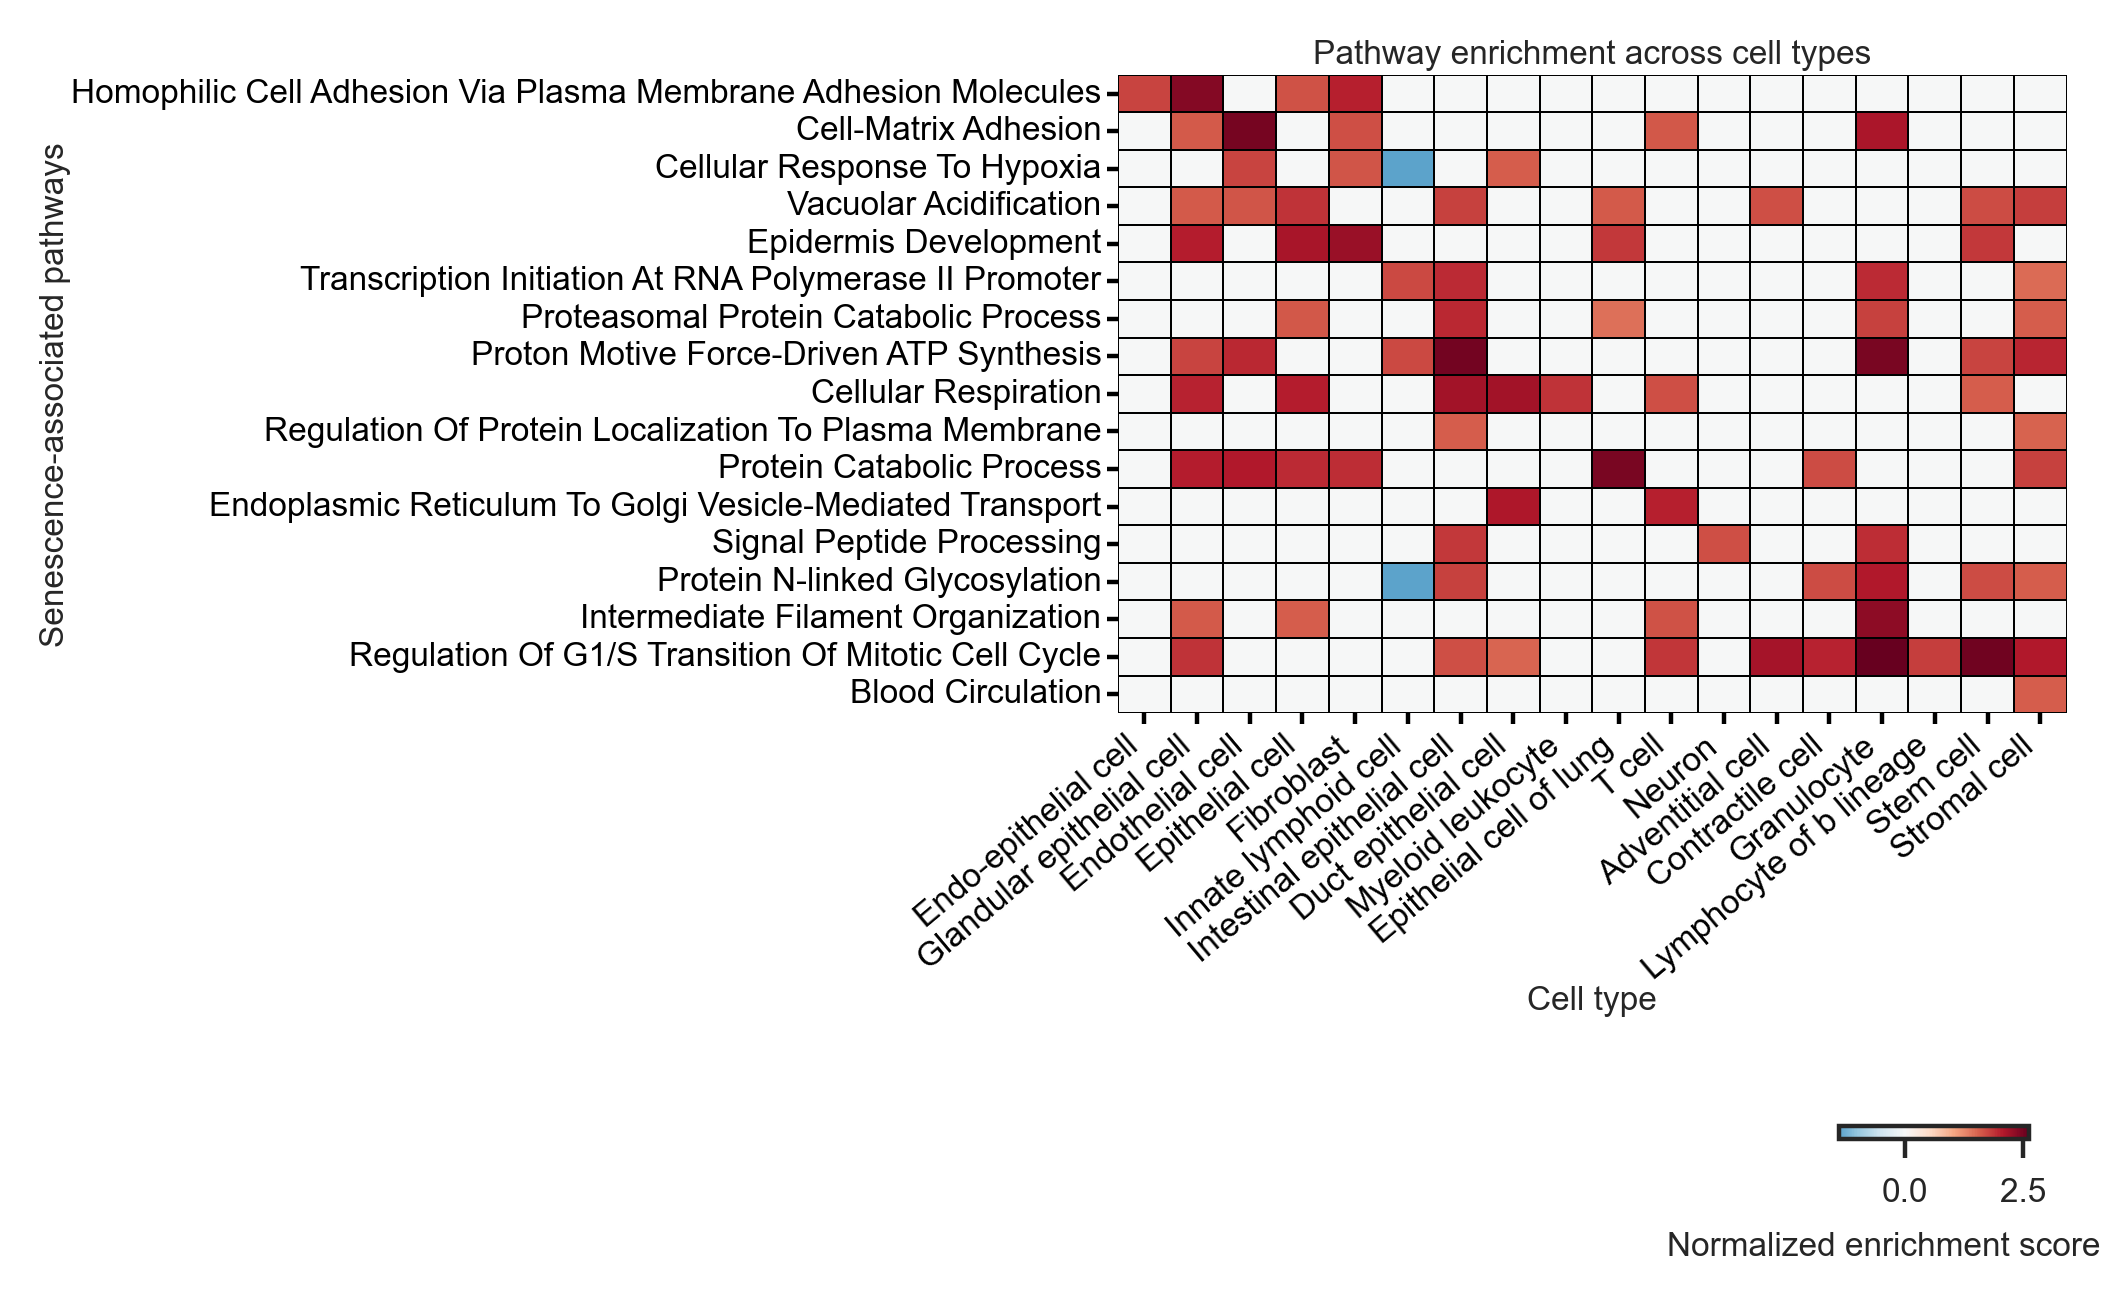

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

term_go_map = dict(zip(pathway_df["GO-ID"], pathway_df["Pathway"]))
# term_go_map = {key: term_go_map[key] for key in term_go_map if key in usage_norm_celltypes_norm.index.values}

sc.settings.set_figure_params(dpi=200, dpi_save= 300, fontsize=6, facecolor='white', frameon=True, figsize=(2.0, 2.0), vector_friendly = True, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize = (3.8,3.5))
plt.grid(False)
sns.set_style("ticks")
g = sns.heatmap(usage_norm_celltypes_norm.T.rename(index=term_go_map), cmap = "RdBu_r", 
                linewidths = 0.3, center = 0, 
                linecolor = "black", square = False, 
                ax = ax, alpha = 1.0)
# g.set_facecolor('black')
ax.tick_params(axis='both', which='major', pad=1, size = 2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, horizontalalignment='right')
mappable = fig.axes[-1].collections[1]
colorBar = fig.axes[-1]
colorBar.remove()
plt.colorbar(mappable=mappable, ax=ax, anchor = (0.95, 0.0),
             fraction=0.25, aspect=15, orientation = "horizontal",
             shrink = 0.2, label = "Normalized enrichment score (NES)")
# plt.xticks(ticks=np.add(range(temp.T.shape[1]), 0.5), labels=temp.T.index.values, fontsize=5)
# ax.set_xticklabels(np.repeat("", temp.T.shape[1]))
ax.set_xlabel('Cell type', labelpad = 0, size = 6)
ax.set_ylabel('Senescence-associated pathways', labelpad = 0, size = 6)
plt.title("Pathway enrichment across cell types", pad=2)
# plt.show()
plt.savefig("human_figures/celltype_specific_SCs_phenotypes.pdf")

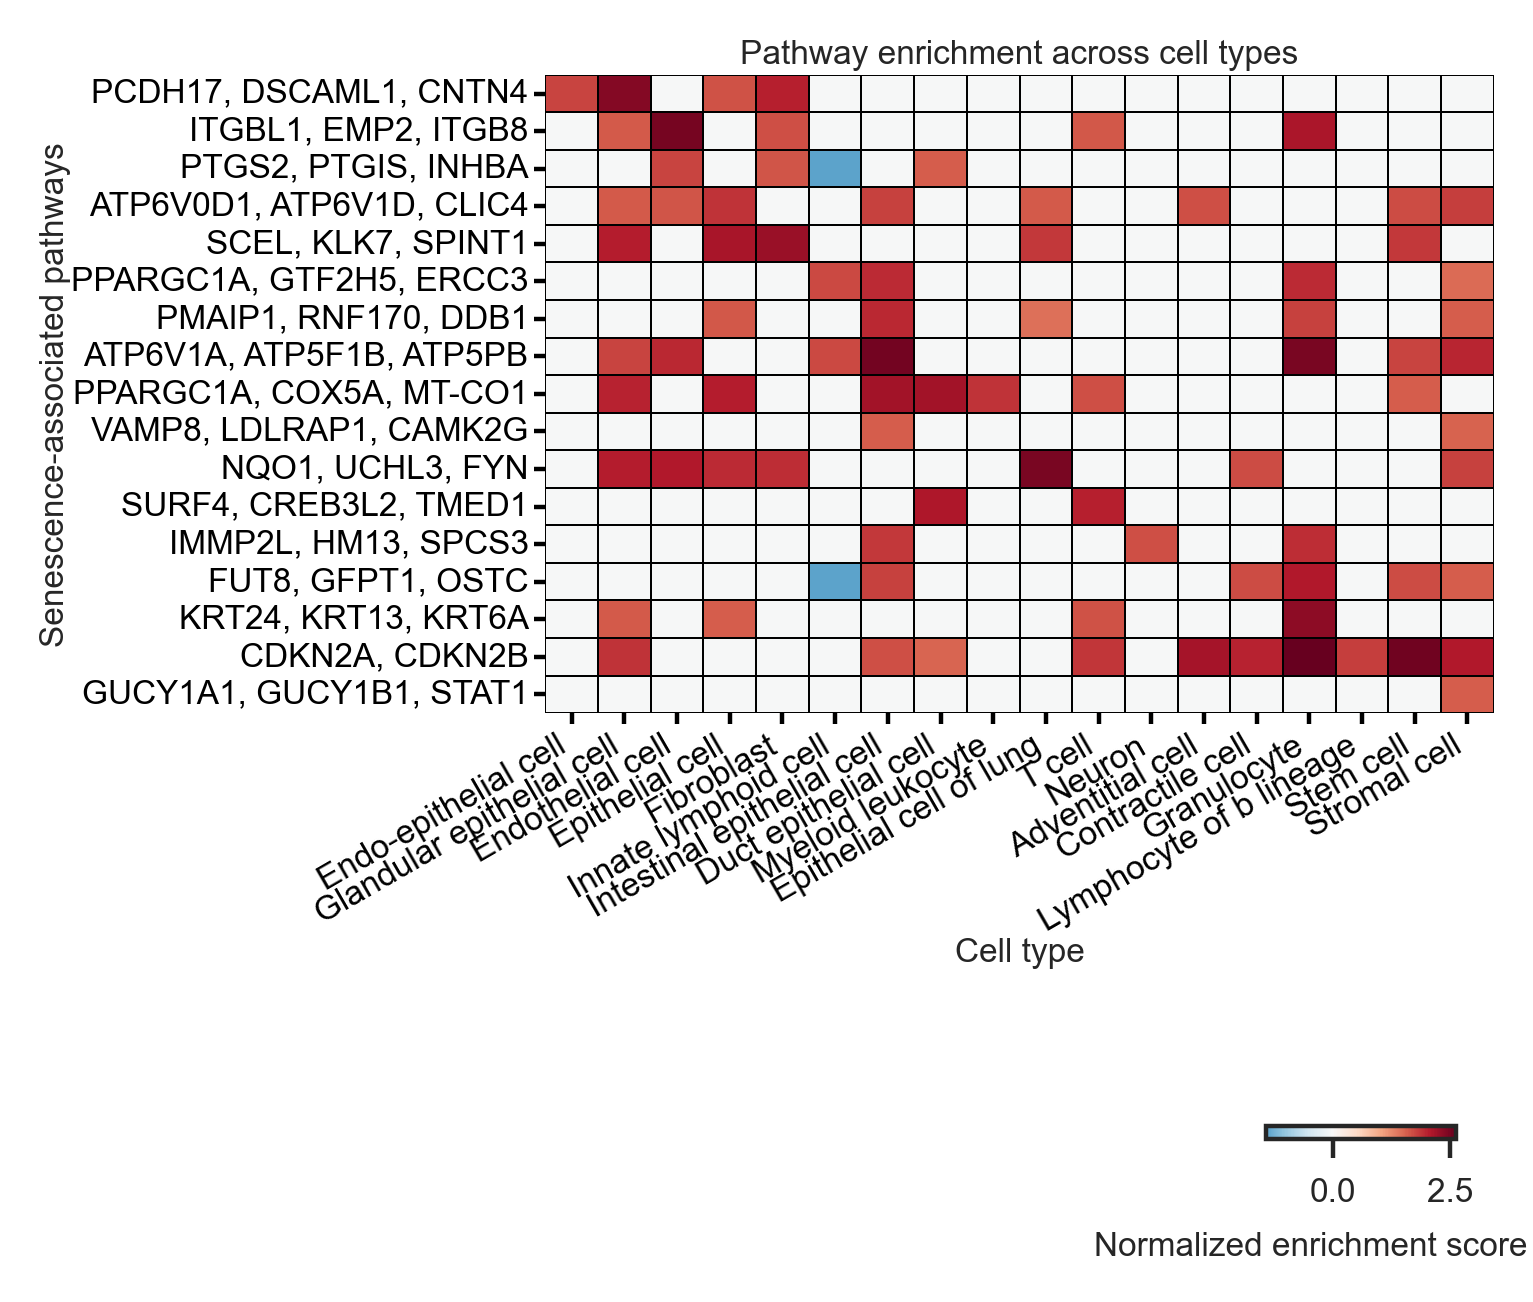

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

siggenes_go_map = dict(zip(sig["Term"], sig["Lead_genes"]))
siggenes_go_map = {key: ", ".join(siggenes_go_map[key].split(";")[: min(len(siggenes_go_map[key].split(";")), 3)]) for key in siggenes_go_map}

sc.settings.set_figure_params(dpi=200, dpi_save= 300, fontsize=6, facecolor='white', frameon=True, figsize=(2.0, 2.0), vector_friendly = True, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize = (3.8,3.5))
plt.grid(False)
sns.set_style("ticks")
g = sns.heatmap(usage_norm_celltypes_norm.T.rename(index=siggenes_go_map), cmap = "RdBu_r", 
                linewidths = 0.3, center = 0, 
                linecolor = "black", square = False, ax = ax, alpha = 1.0)
# g.set_facecolor('black')
ax.tick_params(axis='both', which='major', pad=1, size = 2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
mappable = fig.axes[-1].collections[1]
colorBar = fig.axes[-1]
colorBar.remove()
plt.colorbar(mappable=mappable, ax=ax, anchor = (0.95, 0.0),
             fraction=0.25, aspect=15, orientation = "horizontal",
             shrink = 0.2, label = "Normalized enrichment score (NES)")
# plt.xticks(ticks=np.add(range(temp.T.shape[1]), 0.5), labels=temp.T.index.values, fontsize=5)
# ax.set_xticklabels(np.repeat("", temp.T.shape[1]))
ax.set_xlabel('Cell type', labelpad = 0, size = 6)
ax.set_ylabel('Senescence-associated pathways', labelpad = 0, size = 6)
plt.title("Pathway enrichment across cell types", pad=2)
# plt.show()
plt.savefig("human_figures/celltype_specific_SCs_phenotypes_with_genes.pdf")

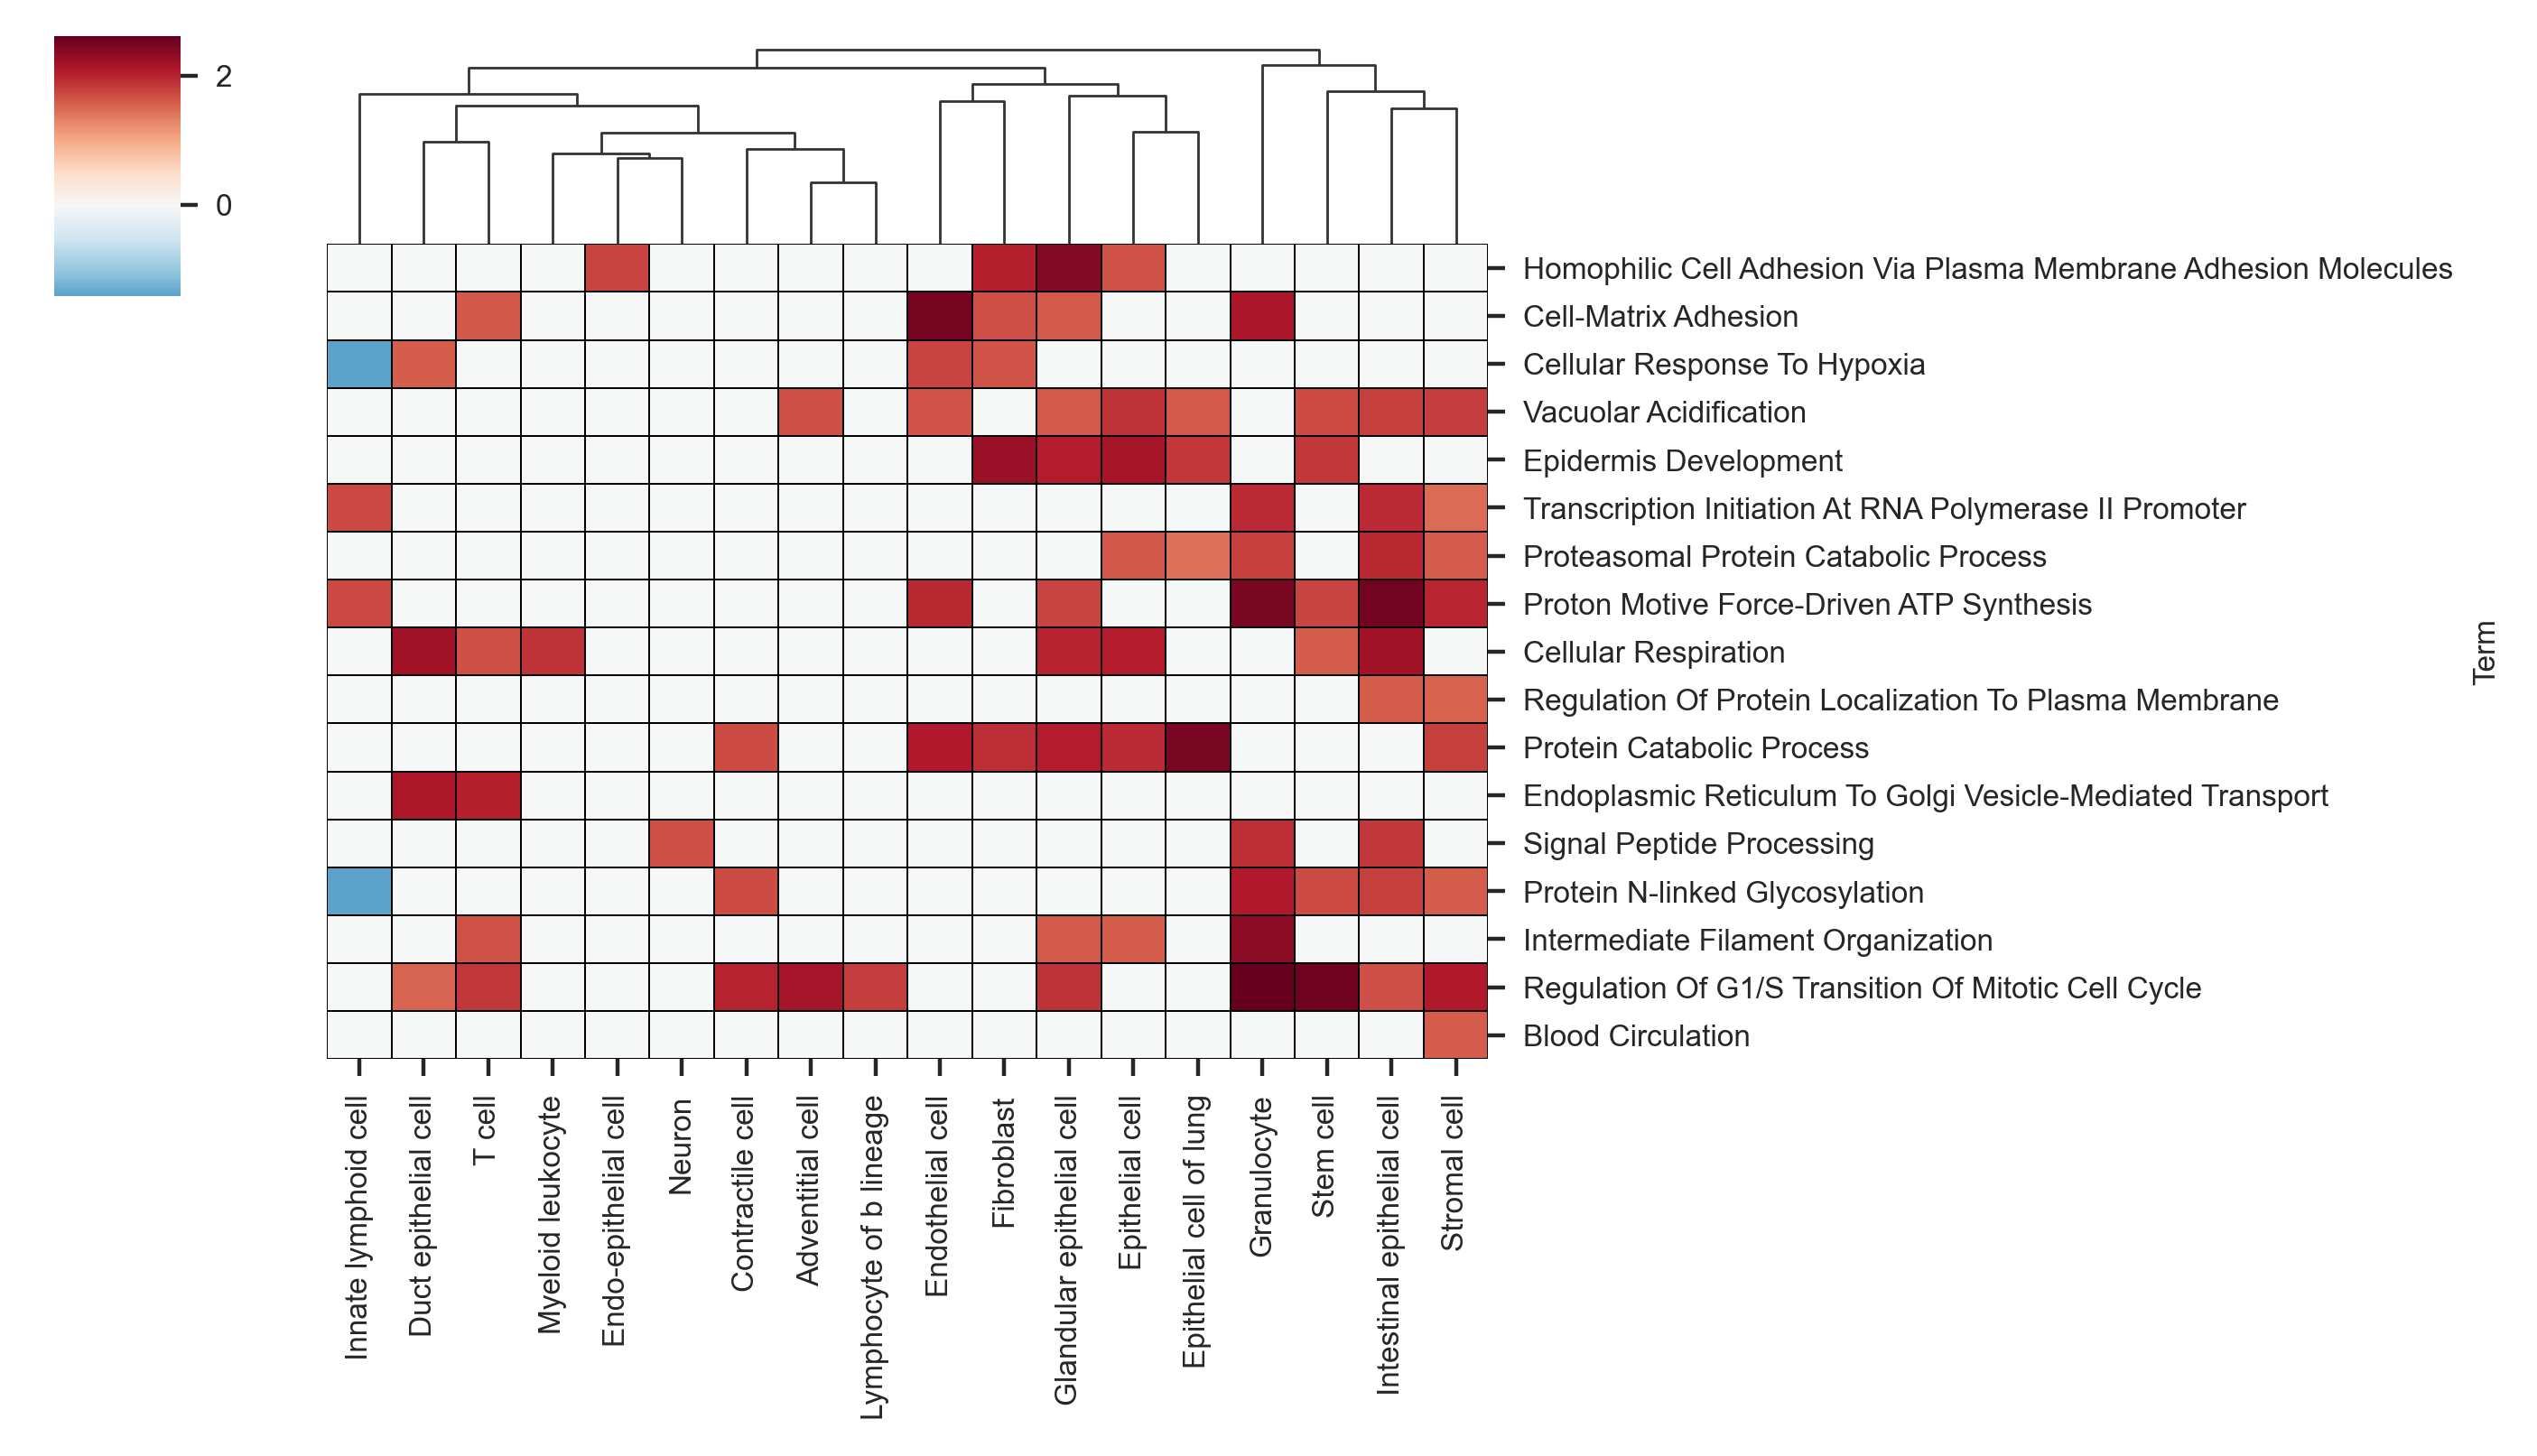

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

term_go_map = dict(zip(pathway_df["GO-ID"], pathway_df["Pathway"]))
# term_go_map = {key: term_go_map[key] for key in term_go_map if key in usage_norm_celltypes_norm.index.values}

sc.settings.set_figure_params(dpi=200, dpi_save= 300, fontsize=6, facecolor='white', frameon=True, figsize=(2.0, 2.0), vector_friendly = True, transparent=True, format="pdf")

sns.set_style("ticks")
g = sns.clustermap(usage_norm_celltypes_norm.T.rename(index=term_go_map), cmap = "RdBu_r", 
                linewidths = 0.3, center = 0, figsize=(7,4), row_cluster=False,
                linecolor = "black", square = False, alpha = 1.0)




In [ ]:
clustermap